In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import scikitplot as skplt

In [2]:
sns.set()

In [28]:
dataset = pd.read_csv('Kepler_dataset_file_edited.csv')

In [29]:
unedited_dataset = pd.read_csv('data.csv')

In [30]:
dataset.head()

,planet_disposition,koi_pdisposition,planet_disp_confidence,flag_nTransitLk,flag_scndEvent,flag_centroidOffset,flag_ephMatch,orbital_period,transit_epoch,impact_parameter,...,equ_temp,insolation_flux,transit_sigToNoise,koi_tce_plnt_num,stellar_eff_temp,stellar_surf_gravity,stellar_radius,right_acension,declination,kepler_magnitude
0,0,1,1.000,0,0,0,0,9.488036,170.538750,0.146,...,793.0,93.59,35.8,1.0,5455.0,4.467,0.927,291.93423,48.141651,15.347
1,0,1,0.969,0,0,0,0,54.418383,162.513840,0.586,...,443.0,9.11,25.8,2.0,5455.0,4.467,0.927,291.93423,48.141651,15.347
2,2,2,0.000,0,1,0,0,19.899140,175.850252,0.969,...,638.0,39.30,76.3,1.0,5853.0,4.544,0.868,297.00482,48.134129,15.436
3,2,2,0.000,0,1,0,0,1.736952,170.307565,1.276,...,1395.0,891.96,505.6,1.0,5805.0,4.564,0.791,285.53461,48.285210,15.597
4,0,1,1.000,0,0,0,0,2.525592,171.595550,0.701,...,1406.0,926.16,40.9,1.0,6031.0,4.438,1.046,288.75488,48.226200,15.509


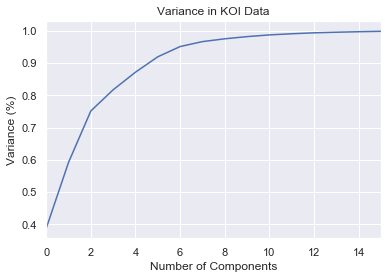

In [31]:
data = dataset.values

scaler = MinMaxScaler(feature_range=[0, 1])

# Removing first two columns because they are labels
rescaled_data = scaler.fit_transform(data[:, 2:])

pca = PCA().fit(rescaled_data)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.xlim((0,15))
plt.title('Variance in KOI Data')
plt.savefig('images/KOI_PCA.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [32]:
pca = PCA(n_components=8)
dataset = pca.fit_transform(rescaled_data)
dataset.shape

(9201, 8)

In [33]:
dataset

array([[-0.62980788, -0.09511614, -0.16975318, ..., -0.00347593,
         0.08450868, -0.06323585],
       [-0.61410949, -0.08971584, -0.15963141, ..., -0.00215517,
         0.06842602, -0.0649999 ],
       [ 0.53346583, -0.65236499,  0.3973753 , ..., -0.16846576,
        -0.02069232, -0.12790812],
       ...,
       [-0.2996045 , -0.04424732, -0.00087849, ...,  0.24125874,
        -0.25415296, -0.02823014],
       [ 0.51010207,  0.26891805, -0.43817176, ...,  0.11173355,
        -0.2413731 , -0.05642931],
       [ 0.83346715,  0.49856271, -0.82081324, ..., -0.17172532,
        -0.18459879, -0.02217342]])

## ---------------------------------------------------------------------------------------
## Splitting into training and testing datasets
## ---------------------------------------------------------------------------------------

In [34]:
# classification = data[:, 1:2] # koi_pdisposition
classification = data[:, :1]
train, test, trainC, testC = train_test_split(dataset, classification, test_size=0.33, random_state=0)

print("Training set size: ", train.shape)
print("Test set size: ", test.shape)

Training set size:  (6164, 8)
Test set size:  (3037, 8)


## ---------------------------------------------------------------------------------------
## MODELS
## ---------------------------------------------------------------------------------------

In [35]:
# target_names = ['CANDIDATE', 'FALSE POSITIVE'] # koi_pdisposition
target_names = ['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE']

def run_model(model):
    # Train and fit the model
    model.fit(train, trainC.ravel())
    # Predict the test data
    predictions = model.predict(test)
    # Compute model metrics
    overall_precision = np.mean(predictions == testC.ravel()) 
    print("Overall Precision: ", overall_precision)
    report = classification_report(predictions, testC, target_names=target_names, output_dict=True)
    report = pd.DataFrame(data=report).drop(['accuracy', 'macro avg', 'weighted avg'], axis=1)
    print("\n", report)
    return report.drop(['precision', 'recall', 'support']) 

## Naive Bayes

In [36]:
gc = GaussianNB()
gc_report = run_model(gc)

Overall Precision:  0.8221929535726046

              CONFIRMED   CANDIDATE  FALSE POSITIVE
precision     0.928205    0.342736        0.988372
recall        0.617221    0.815436        0.977011
f1-score      0.741423    0.482622        0.982659
support    1173.000000  298.000000     1566.000000


## KNN

In [37]:
knn = KNeighborsClassifier(n_neighbors=7)
knn_report = run_model(knn)

Overall Precision:  0.8212051366480079

             CONFIRMED   CANDIDATE  FALSE POSITIVE
precision    0.753846    0.533145        0.987080
recall       0.646154    0.656250        0.985171
f1-score     0.695858    0.588327        0.986125
support    910.000000  576.000000     1551.000000


## SVM

In [39]:
svm = SVC(gamma='auto', probability=True)
svm_report = run_model(svm)

Overall Precision:  0.8195587751070135

              CONFIRMED   CANDIDATE  FALSE POSITIVE
precision     0.956410    0.300423        0.988372
recall        0.606998    0.862348        0.980141
f1-score      0.742658    0.445607        0.984239
support    1229.000000  247.000000     1561.000000


## Decision Tree

In [40]:
dt = tree.DecisionTreeClassifier()
dt_report = run_model(dt)

Overall Precision:  0.8027658873888706

             CONFIRMED   CANDIDATE  FALSE POSITIVE
precision    0.638462    0.590973        0.982558
recall       0.638462    0.595170        0.979395
f1-score     0.638462    0.593064        0.980974
support    780.000000  704.000000     1553.000000


## ---------------------------------------------------------------------------------------
## MODEL ANALYSIS
## ---------------------------------------------------------------------------------------

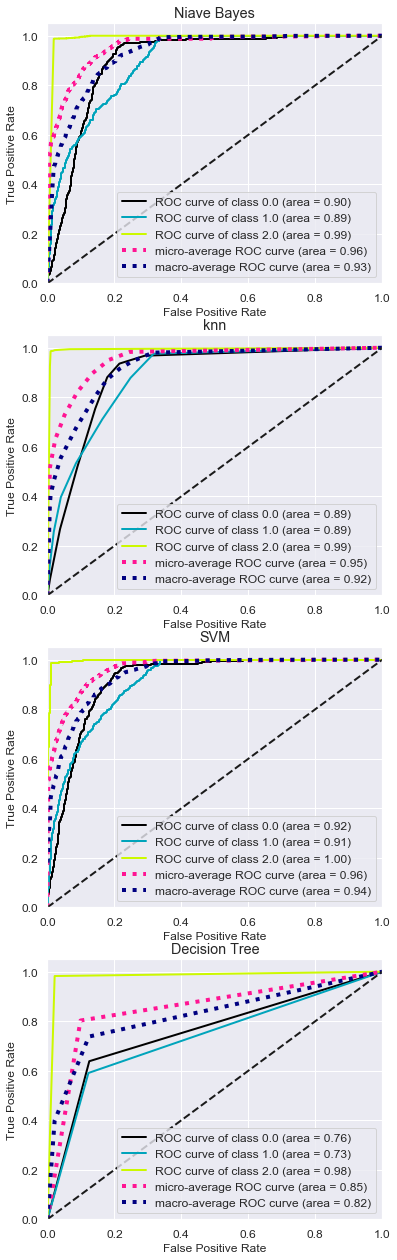

In [41]:
def plot_roc(ax, model, title):
    probas = model.predict_proba(test)
    skplt.metrics.plot_roc(y_true=testC, y_probas=probas, ax=ax, title=title)

models = [(gc, "Niave Bayes"), (knn, "knn"), (svm, "SVM"), (dt, "Decision Tree")]
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6,22))
for ax, model in zip(axes, models):
    plot_roc(ax, model[0], model[1])
    
plt.savefig('images/KOI_ROC.png', 
            dpi=300, bbox_inches='tight')

In [21]:
reports = [gc_report, knn_report, svm_report, dt_report]
cumulative = pd.DataFrame()
for report in reports:
    cumulative = pd.concat([cumulative, report])
    
cumulative.set_index(pd.Index(["Naive Bayes f1-score", "KNN f1-score",
                               "SVM f1-score", "Decision Tree f1-score"]))

,CONFIRMED,CANDIDATE,FALSE POSITIVE
Naive Bayes f1-score,0.741423,0.482622,0.982659
KNN f1-score,0.695858,0.588327,0.986125
SVM f1-score,0.742658,0.445607,0.984239
Decision Tree f1-score,0.626367,0.584507,0.979025
